# Lout

The objective of this script is analyze the air Lout over the PV field comparing it to the desert background

In [1]:
import pandas as pd
import openpyxl
import numpy as np
import glob
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy import signal
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from scipy import stats
import os
from plotnine.data import mtcars
from itertools import product

### Input and output paths

In [2]:
project_path = 'D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/'   # Weizmann desktop
#project_path = 'C:/Users/rafas/Dropbox/Doutorado/Working/Ketura/'     # notebook
input_path   = project_path + '01_data/'
output_path  = project_path + '02_output/'
graphs_path  = project_path + '03_graphs/'

# Functions

In [3]:
# Loads all data in the folder
def load_all_data(path):
    file_list = sorted(glob.glob(path + '*corr.csv', recursive=True))

    data_list = []
    for filename in file_list:
        fn_without_path = filename.replace(path[:-1], "")[1:]
        print("Loading", fn_without_path)
        
        temp = pd.read_csv(filename)
        
        temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)
        # creating 'Time' column
        temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
        
        temp.loc[temp['Month'] == 'July', 'Season'] = 'Summer'
        temp.loc[temp['Month'] == 'October', 'Season'] = 'Autumn'
        temp.loc[temp['Month'] == 'March', 'Season'] = 'Spring'
        temp.loc[temp['Ecosystem'] == 'Solar', 'Ecosystem'] = 'PV field'
        temp.loc[temp['Ecosystem'] == 'Desert', 'Ecosystem'] = 'Desert background'
        
        data_list.append(temp)
        
    # Combine all the read data
    df = pd.concat(data_list, axis=0, ignore_index=True)
    
    # Rename
    df.rename(columns={'LW_OUT_average_corr': 'Lout'}, inplace=True)
    df.rename(columns={'LW_IN_average_corr': 'Lin'}, inplace=True)
       
    # Convert columns to float
    df['Lout']  = pd.to_numeric(df['Lout'], downcast="float")
    df['Lin']  = pd.to_numeric(df['Lin'], downcast="float")
    
    # Keep only relevant columns
    df = df[['DateTime','Season','Ecosystem','Lout','Lin','Time']]
    
    return(df)

def rename_and_convert_drone(df):
    
    # Rename
    df.rename(columns={'LW_IN_average_corr': 'Lin_from_drone'}, inplace=True)
    df.rename(columns={'LWout_corr_bydrone': 'Lout_from_drone'}, inplace=True)
    df.rename(columns={'SW_IN_average': 'SWin'}, inplace=True)

       
    # Convert columns to float
    df['H']  = pd.to_numeric(df['H'], downcast="float")
    df['LE'] = pd.to_numeric(df['LE'], downcast="float")
    df['Lin_from_drone']  = pd.to_numeric(df['Lin_from_drone'], downcast="float")
    df['Lout_from_drone'] = pd.to_numeric(df['Lout_from_drone'], downcast="float")
    df['SWin']  = pd.to_numeric(df['SWin'], downcast="float")

    # Estimating SWout based on the fixed albedo value from March 2018 (0.23)
    df['SWout'] = df['SWin']*0.24
    df['PVeff'] = 0.058
    df['PVe'] = df['SWin'] * df['PVeff'] 

    # Calculating Rn
    df['Rn_from_drone'] = df['SWin'] - df['SWout'] + df['Lin_from_drone'] - df['Lout_from_drone']
    df['Rn_from_drone_pv'] = df['SWin'] - df['SWout'] + df['Lin_from_drone'] - df['Lout_from_drone'] - df['PVe']
    
    df['Ecosystem'] = 'PV field'
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month

    
    # Keep only relevant columns
    df = df[['DateTime','Season','Year','Ecosystem','H','LE','Lout_from_drone','Rn_from_drone','Rn_from_drone_pv','PVeff','PVe','SWin']] 
         
    return(df)

def averaging(temp):
    
    # define mid-day
    #temp = temp.loc[(temp['DateTime'].dt.hour >= 10) & (temp['DateTime'].dt.hour < 15)].copy() 

    # Make mean and std dev
    df_means = temp.groupby(['Season','Ecosystem']).mean().reset_index()
    df_sds   = temp.groupby(['Season','Ecosystem']).std().reset_index()
    # rename columns
    df_means.rename(columns={'Lout': 'Lout_mean'}, inplace=True)
    
    df_sds.rename(columns={'Lout': 'Lout_sd'}, inplace=True)
    
    merged = df_means.merge(df_sds, on=['Season','Ecosystem'])
    
    return(merged)

def diurnal(temp, Ecosystem, Season):
    
    temp = temp.loc[(temp['Ecosystem'] == Ecosystem) & (temp['Season'] == Season)].copy()
    
    # creating 'Time' column
    temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
    
    # Keep only relevant columns
    temp = temp[['Time','Ecosystem','Lout']]
    
    # Make mean and std dev
    df_means = temp.groupby(['Ecosystem','Time']).mean().reset_index()
    df_sds   = temp.groupby(['Ecosystem','Time']).std().reset_index()
    # rename columns
    df_means.rename(columns={'Lout': 'Lout_mean'}, inplace=True)
    
    df_sds.rename(columns={'Lout': 'Lout_sd'}, inplace=True)
    
    merged = df_means.merge(df_sds, on=['Ecosystem','Time'])
    
    return(merged)

def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    return(p_text)

def ttest_all(temp, category, list_of_test_cols, group_col):
    # Prepare name of categories to test against each other
    group1 = temp[group_col].unique()[0]
    group2 = temp[group_col].unique()[1]
    print('Testing', group1, '&', group2)
    
    # Prepare df for results
    out_df = pd.DataFrame(list(product(list_of_test_cols, temp[category].dropna().unique())), columns=['Parameter', category])
    out_df['p'] = np.nan
    
    # Do t-tests for all combinations
    for col in list_of_test_cols:
        #print('----')
        #print(col)
        for cat in temp[category].dropna().unique():
            #print(cat)
            a = temp.loc[(temp[group_col] == group1) & (temp[category] == cat),col]
            b = temp.loc[(temp[group_col] == group2) & (temp[category] == cat),col]
            t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
            print(col, cat, ':', pvalue_text(t[1]))
            # Add data to resulting df
            out_df.loc[(out_df[category] == cat) & (out_df['Parameter'] == col), 'p'] = pvalue_text(t[1])
    
    return(out_df)

In [4]:
def calculate_Lemitted(Lsensor, Lin, emissivity):
    Lemitted = Lsensor - (1 - emissivity)*Lin
    return(Lemitted)

def calculate_Lout_from_Lemitted(Lemitted, Lin, emissivity):
    Lout = Lemitted + (1 - emissivity)*Lin
    return(Lout)

In [5]:
mast_df = load_all_data(input_path)

# Prepare empty Lemitted and emissivity columns
mast_df['Lemitted'] = np.nan
mast_df['emissivity'] = np.nan

# Add emissivity
mast_df.loc[mast_df['Ecosystem'] == 'Desert background', 'emissivity'] = 0.87
mast_df.loc[mast_df['Ecosystem'] == 'PV field', 'emissivity'] = 0.85 # considering that Irina's measurements for 30 degrees inclination of the panels were 0.83 and 0.84. Therefore, 0.85 would be a good mean for 50% panels (0.83-0.84) and 50% soil (0.87) cover of the field

mast_df['Lemitted'] = calculate_Lemitted(mast_df['Lout'], mast_df['Lin'], mast_df['emissivity']) # Replace the already corrected ones
# NOTE: PV field values in Summer & Autumn need to be replaced using the drone data

display (mast_df)

Loading Ketura_all_corr.csv
Loading Yatir_desert_all_corr.csv


,DateTime,Season,Ecosystem,Lout,Lin,Time,Lemitted,emissivity
0,2019-07-09 20:30:00+00:00,Summer,Desert background,503.072601,407.393005,20:30,450.111511,0.87
1,2019-07-09 21:00:00+00:00,Summer,Desert background,497.234985,400.308990,21:00,445.194817,0.87
2,2019-07-09 21:30:00+00:00,Summer,Desert background,492.450989,396.226013,21:30,440.941607,0.87
3,2019-07-09 22:00:00+00:00,Summer,Desert background,488.117004,393.476013,22:00,436.965123,0.87
4,2019-07-09 22:30:00+00:00,Summer,Desert background,484.428009,391.584991,22:30,433.521960,0.87
...,...,...,...,...,...,...,...,...
2872,2015-08-29 23:00:00+00:00,NaN,Yatir,417.607605,329.941986,23:00,NaN,NaN
2873,2015-08-29 23:30:00+00:00,NaN,Yatir,415.586853,330.522003,23:30,NaN,NaN
2874,2015-08-30 00:00:00+00:00,NaN,Yatir,415.492798,331.742004,00:00,NaN,NaN
2875,2015-08-30 00:30:00+00:00,NaN,Yatir,412.988922,332.226990,00:30,NaN,NaN


## Load drone data

In [6]:
drone_df = pd.read_csv(input_path + "final_truck_LWout_corrected.csv") 
drone_df['DateTime'] = pd.to_datetime(drone_df['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)
drone_df['Month'] = drone_df['DateTime'].dt.month

drone_df.loc[drone_df['Month'] == 7, 'Season'] = 'Summer'
drone_df.loc[drone_df['Month'] == 10, 'Season'] = 'Autumn'
drone_df.loc[drone_df['Month'] == 11, 'Season'] = 'Autumn'

drone_df = rename_and_convert_drone(drone_df)

display (drone_df)

,DateTime,Season,Year,Ecosystem,H,LE,Lout_from_drone,Rn_from_drone,Rn_from_drone_pv,PVeff,PVe,SWin
0,2019-07-16 14:30:00+00:00,Summer,2019,PV field,304.852997,28.705700,598.822998,498.863770,445.999032,0.058,52.864738,911.460999
1,2019-07-16 15:00:00+00:00,Summer,2019,PV field,366.420990,44.638302,593.456543,453.898193,405.017823,0.058,48.880371,842.765015
2,2019-07-16 15:30:00+00:00,Summer,2019,PV field,291.721985,16.261700,591.434753,394.885010,350.857615,0.058,44.027395,759.093018
3,2019-07-16 16:00:00+00:00,Summer,2019,PV field,314.447998,20.247400,583.401672,333.348328,294.866489,0.058,38.481839,663.479980
4,2019-07-16 16:30:00+00:00,Summer,2019,PV field,208.761002,20.630100,574.480713,267.213013,234.491210,0.058,32.721802,564.169006
...,...,...,...,...,...,...,...,...,...,...,...,...
746,2018-11-01 05:30:00+00:00,Autumn,2018,PV field,NaN,NaN,457.498688,-128.382385,-128.415275,0.058,0.032890,0.567066
747,2018-11-01 06:00:00+00:00,Autumn,2018,PV field,NaN,NaN,458.583893,-102.791687,-104.875296,0.058,2.083609,35.924301
748,2018-11-01 06:30:00+00:00,Autumn,2018,PV field,NaN,NaN,462.913452,-39.581940,-46.854328,0.058,7.272388,125.386002
749,2018-11-01 07:00:00+00:00,Autumn,2018,PV field,NaN,NaN,462.260071,30.065399,17.745963,0.058,12.319436,212.404068


## Combine mast and drone data

In [8]:
# Merge
all_df = mast_df.merge(drone_df[['DateTime','Season','Ecosystem','Lout_from_drone']], how='outer', on=['DateTime','Season','Ecosystem']) 

# Replace Lemitted (mast) from drone in Summer & Atumn in the PV field only
all_df.loc[((all_df['Season'].isin(['Summer','Autumn'])) & (all_df['Ecosystem'] == 'PV field')), 'Lout'] = \
                   all_df.loc[((all_df['Season'].isin(['Summer','Autumn'])) & (all_df['Ecosystem'] == 'PV field')), 'Lout_from_drone']

# Calculate Lout from the drone Lemitted
all_df.loc[((all_df['Season'].isin(['Summer','Autumn'])) & (all_df['Ecosystem'] == 'PV field')), 'Lemitted'] = calculate_Lemitted( \
                   all_df.loc[((all_df['Season'].isin(['Summer','Autumn'])) & (all_df['Ecosystem'] == 'PV field')), 'Lout_from_drone'], \
                   all_df.loc[((all_df['Season'].isin(['Summer','Autumn'])) & (all_df['Ecosystem'] == 'PV field')), 'Lin'], \
                   all_df.loc[((all_df['Season'].isin(['Summer','Autumn'])) & (all_df['Ecosystem'] == 'PV field')), 'emissivity'])

# Clean up
all_df.drop('Lout_from_drone', axis=1, inplace=True)

display (all_df)

,DateTime,Season,Ecosystem,Lout,Lin,Time,Lemitted,emissivity
0,2019-07-09 20:30:00+00:00,Summer,Desert background,503.072601,407.393005,20:30,450.111511,0.87
1,2019-07-09 21:00:00+00:00,Summer,Desert background,497.234985,400.308990,21:00,445.194817,0.87
2,2019-07-09 21:30:00+00:00,Summer,Desert background,492.450989,396.226013,21:30,440.941607,0.87
3,2019-07-09 22:00:00+00:00,Summer,Desert background,488.117004,393.476013,22:00,436.965123,0.87
4,2019-07-09 22:30:00+00:00,Summer,Desert background,484.428009,391.584991,22:30,433.521960,0.87
...,...,...,...,...,...,...,...,...
2872,2015-08-29 23:00:00+00:00,NaN,Yatir,417.607605,329.941986,23:00,NaN,NaN
2873,2015-08-29 23:30:00+00:00,NaN,Yatir,415.586853,330.522003,23:30,NaN,NaN
2874,2015-08-30 00:00:00+00:00,NaN,Yatir,415.492798,331.742004,00:00,NaN,NaN
2875,2015-08-30 00:30:00+00:00,NaN,Yatir,412.988922,332.226990,00:30,NaN,NaN


In [6]:
# df['Period'] = 'None'
# df.loc[(df['DateTime'].dt.hour >= 14) & (df['DateTime'].dt.hour < 16), 'Period'] = 'Day'
# df.loc[(df['DateTime'].dt.hour >= 5) & (df['DateTime'].dt.hour < 6), 'Period'] = 'Night'

# display (df)

In [7]:
# day_df = df.loc[(df['Period'] == 'Night')].copy()
# day_df_ecosystem = day_df.loc[(day_df['Ecosystem'] == 'PV field')].copy()
# day_df_season = day_df_ecosystem.loc[(day_df_ecosystem['Season'] == 'Spring')].copy()

# #display(day_df)
# display(day_df_season)

# day_df_season.describe()

In [8]:
# night_df = df.loc[(df['Period'] == 'Night')].copy()

# display(night_df)

# night_df.describe()

In [14]:
mean_df = averaging(all_df).round(1).copy()

# Move Season to the front
col = mean_df.pop('Season')
mean_df.insert(0, col.name, col)
# Create a text of summarised values (mean + stddev)
mean_df['Lout'] = mean_df['Lout_mean'].astype(int).astype(str) + ' (' + mean_df['Lout_sd'].astype(int).astype(str) + ')'
# Remove the original values
mean_df.drop(['Lout_mean','Lout_sd'], axis=1, inplace=True)
#mean_df = mean_df.pivot(index='Ecosystem', columns='Season').stack(level=[0])

#mean_df.to_latex(output_path + 'Ketura_radiative_fluxes_new.tex', index=True)

# Remove the original values
mean_df.drop(['Lin_x','Lemitted_x','emissivity_x','Lin_y','Lemitted_y','emissivity_y'], axis=1, inplace=True)

display(mean_df)

,Season,Ecosystem,Lout
0,Autumn,Desert background,468 (36)
1,Autumn,PV field,479 (21)
2,Spring,Desert background,451 (47)
3,Spring,PV field,446 (42)
4,Summer,Desert background,520 (54)
5,Summer,PV field,522 (48)


# t-tests

### Seasonal means

In [15]:
# Prepare table
final_df = mean_df.pivot(index='Season', columns='Ecosystem').stack(level=[0])
display(final_df)

final_df = final_df.reset_index()
#final_df['P'] = ''
final_df.rename(columns={'level_1': 'Parameter'}, inplace=True)

p_df = ttest_all(all_df, 'Season', ['Lout'], 'Ecosystem')

final_df = final_df.merge(p_df, on = ['Parameter', 'Season'], how='left').copy()

display(final_df)
final_df.to_latex(output_path + 'Ketura_Lout_new.tex', index=False)

,Ecosystem,Desert background,PV field
Season,,,
Autumn,Lout,468 (36),479 (21)
Spring,Lout,451 (47),446 (42)
Summer,Lout,520 (54),522 (48)


Testing Desert background & PV field
Lout Summer : 0.61
Lout Spring : 0.26
Lout Autumn : <.001


,Season,Parameter,Desert background,PV field,p
0,Autumn,Lout,468 (36),479 (21),<.001
1,Spring,Lout,451 (47),446 (42),0.26
2,Summer,Lout,520 (54),522 (48),0.61


### Diurnal cycles

In [16]:
#df.drop(['DateTime'], axis=1, inplace=True)
display (all_df)

# Make mean and std dev
df_means = all_df.groupby(['Ecosystem','Season','Time']).mean().reset_index()
df_sds   = all_df.groupby(['Ecosystem','Season','Time']).std().reset_index()
# rename columns
df_means.rename(columns={'Lout': 'Lout_mean'}, inplace=True)
df_sds.rename(columns={'Lout': 'Lout_sd'}, inplace=True)

all_df_diurnal = df_means.merge(df_sds, on=['Ecosystem','Season','Time'])
all_df_diurnal['Season'] = pd.Categorical(all_df_diurnal['Season'], ordered=True, categories=['Spring','Summer','Autumn'])
# Remove the original values
all_df_diurnal.drop(['Lin_x','Lemitted_x','emissivity_x','Lin_y','Lemitted_y','emissivity_y'], axis=1, inplace=True)

display (all_df_diurnal)

,DateTime,Season,Ecosystem,Lout,Lin,Time,Lemitted,emissivity
0,2019-07-09 20:30:00+00:00,Summer,Desert background,503.072601,407.393005,20:30,450.111511,0.87
1,2019-07-09 21:00:00+00:00,Summer,Desert background,497.234985,400.308990,21:00,445.194817,0.87
2,2019-07-09 21:30:00+00:00,Summer,Desert background,492.450989,396.226013,21:30,440.941607,0.87
3,2019-07-09 22:00:00+00:00,Summer,Desert background,488.117004,393.476013,22:00,436.965123,0.87
4,2019-07-09 22:30:00+00:00,Summer,Desert background,484.428009,391.584991,22:30,433.521960,0.87
...,...,...,...,...,...,...,...,...
2872,2015-08-29 23:00:00+00:00,NaN,Yatir,417.607605,329.941986,23:00,NaN,NaN
2873,2015-08-29 23:30:00+00:00,NaN,Yatir,415.586853,330.522003,23:30,NaN,NaN
2874,2015-08-30 00:00:00+00:00,NaN,Yatir,415.492798,331.742004,00:00,NaN,NaN
2875,2015-08-30 00:30:00+00:00,NaN,Yatir,412.988922,332.226990,00:30,NaN,NaN


,Ecosystem,Season,Time,Lout_mean,Lout_sd
0,Desert background,Autumn,00:00,440.347076,6.818320
1,Desert background,Autumn,00:30,438.579346,7.197545
2,Desert background,Autumn,01:00,436.681000,6.748204
3,Desert background,Autumn,01:30,435.385193,6.540568
4,Desert background,Autumn,02:00,435.050903,6.848551
...,...,...,...,...,...
283,PV field,Summer,21:30,500.137390,10.121655
284,PV field,Summer,22:00,496.576538,9.822005
285,PV field,Summer,22:30,492.683746,9.261914
286,PV field,Summer,23:00,489.485901,9.077622


## Night values

In [17]:
# t-test

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Autumn, night: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Spring, night: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Summer, night: P =', pvalue_text(t[1]))

Autumn, night: P = <.001
Spring, night: P = 0.0
Summer, night: P = <.001


## Day values

In [18]:
# t-test

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Autumn, day: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Spring, day: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Summer, day: P =', pvalue_text(t[1]))

Autumn, day: P = 0.0
Spring, day: P = 0.0
Summer, day: P = 0.64


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 20.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/Lout_diurnal.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "scale" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 20.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/Lout_diurnal.png
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig() got unexpec

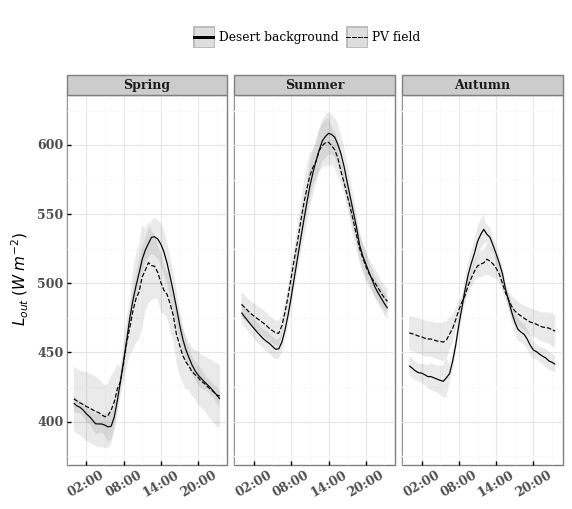

<ggplot: (-9223372005527200056)>

In [19]:
cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
all_df_diurnal['timestamp2'] = pd.to_datetime(all_df_diurnal['Time'], utc=True)

plt = ggplot(all_df_diurnal)
plt = plt + geom_line(aes(x='timestamp2', y='Lout_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='Lout_mean - Lout_sd', ymax='Lout_mean + Lout_sd', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$L_{out} \;(W \; m^{-2})$', parse=True)
plt = plt + facet_wrap(['Season'])
#plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'Lout_diurnal.pdf', width=20, height=10, units='cm', scale=1.3, dpi=600)
plt.save(graphs_path + 'Lout_diurnal.png', width=20, height=10, units='cm', scale=1.3, dpi=600)


plt

In [20]:
mean_df = averaging(df)

mean_df.to_latex(output_path + 'Ketura_Lout_new.tex', index=False, float_format="{:0.1f}".format)

display(mean_df)

NameError: name 'df' is not defined

In [15]:
mean_day_df = averaging(day_df)

mean_day_df.to_latex(output_path + 'Ketura_Lout_day_new.tex', index=False, float_format="{:0.1f}".format)

display(mean_day_df)

NameError: name 'day_df' is not defined

In [16]:
mean_night_df = averaging(night_df)

mean_night_df.to_latex(output_path + 'Ketura_Lout_night_new.tex', index=False, float_format="{:0.1f}".format)

display(mean_night_df)

NameError: name 'night_df' is not defined

In [16]:
diurnal_T_desert_march2018_df = diurnal(df, 'Desert', 'March')
diurnal_T_desert_march2018_df.to_csv(output_path + 'diurnal_T_desert_march2018.csv')

diurnal_T_pv_march2018_df = diurnal(df, 'Solar', 'March')
diurnal_T_pv_march2018_df.to_csv(output_path + 'diurnal_T_pv_march2018.csv')

diurnal_T_desert_october2018_df = diurnal(df, 'Desert', 'October')
diurnal_T_desert_october2018_df.to_csv(output_path + 'diurnal_T_desert_october2018.csv')

diurnal_T_desert_july2019_df = diurnal(df, 'Desert', 'July')
diurnal_T_desert_july2019_df.to_csv(output_path + 'diurnal_T_desert_july2019.csv') 

diurnal_T_pv_october2018_df = diurnal(df, 'Solar', 10)
diurnal_T_pv_october2018_df.to_csv(output_path + 'diurnal_T_pv_october2018.csv')

diurnal_T_pv_july2019_df = diurnal(df, 'Solar', 7)
diurnal_T_pv_july2019_df.to_csv(output_path + 'diurnal_T_pv_july2019.csv') 